In [33]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [34]:
train_data = datasets.FashionMNIST(
    root='data',                          # Save dataset in 'data' folder
    train=True,                           # Load training split (60k images)
    download=True,                        # Download if not available locally
    transform=torchvision.transforms.ToTensor(),  # Convert images to tensors
    target_transform=None                 # applies transformations to the labels/targets
)

test_data = datasets.FashionMNIST(
    root='data',                          # Save in 'data' folder (same as training)
    train=False,                          # Load test split (10k images)
    download=True,                        # Download if missing
    transform=torchvision.transforms.ToTensor(),  # Same transform as training
    target_transform=None                 # applies transformations to the labels/targets
)

In [35]:
# A list of all class names in string format
class_names = train_data.classes

# A dictionary mapping class names to their corresponding integer labels
train_data.class_to_idx

# A tensor or list containing all the labels for the entire dataset
train_data.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [36]:
image, label = train_data[0]
print(f'Image shape: {image.shape}')

Image shape: torch.Size([1, 28, 28])


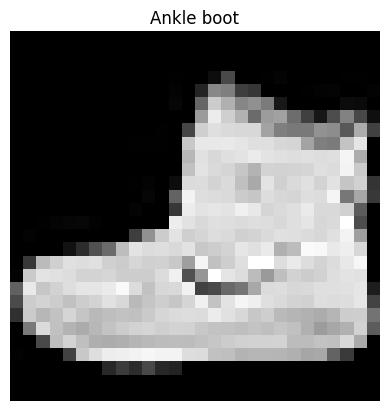

In [37]:
plt.imshow(image.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
plt.show()

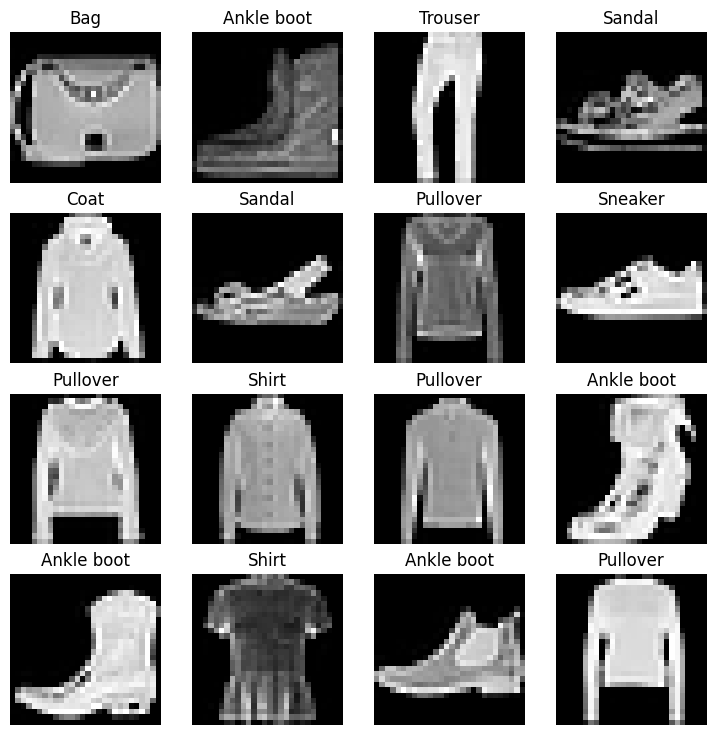

In [38]:
# torch.manual_seed(42)                  
fig = plt.figure(figsize=(9, 9))       # Create 9x9 inch figure for image grid
rows, cols = 4, 4                      # Set grid layout: 4 rows x 4 columns (16 images)

for i in range(1, rows*cols+1):        # Loop to plot 16 subplots (1-indexed)
    random_idx = torch.randint(0, len(train_data), size=[1]).item()  # Pick random dataset index
    # generate a tensor with one random integer inside.

    img, label = train_data[random_idx]  # Load image tensor and its class label
    fig.add_subplot(rows, cols, i)     # Add subplot at position i
    plt.imshow(img.squeeze(), cmap='gray')  # Display image (remove channel dim, use grayscale)
    plt.title(class_names[label])      # Show class name as title
    plt.axis(False)                    # Hide axes for cleaner look

In [39]:
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=32,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=32,
                             shuffle=False)

In [40]:
print(f'Length of train_dataloader: {len(train_dataloader)} batches of 32')
print(f'Length of test_dataloader: {len(test_dataloader)} batches of 32')

Length of train_dataloader: 1875 batches of 32
Length of test_dataloader: 313 batches of 32


In [41]:
# iter(train_dataloader) → turns the DataLoader into an iterator.
# next(...) → pulls the first batch from it.
# This line gets one mini-batch from your training data.
train_features_batch, train_labels_batch = next(iter(train_dataloader)) 

# 32 images, 1 color channel, 28x28 pixels each, 32 labels (one for each image)
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28]) | Label: 1


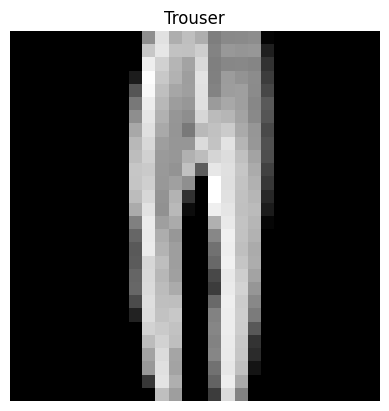

In [42]:
# torch.manual_seed(42)

# Generate random index within dataset range
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()

# Get the image tensor and its corresponding label from the batch at that index
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]

plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis('off')
print(f'Image size: {img.shape} | Label: {label}')
plt.show()

In [43]:
flatten_model = nn.Flatten()

X = train_features_batch[0]

output = flatten_model(X)

print(f'Shape before flattening: {X.shape}')
print(f'Shape after flattening: {output.shape}')

Shape before flattening: torch.Size([1, 28, 28])
Shape after flattening: torch.Size([1, 784])


In [44]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_0 = FashionMNISTModelV0(input_shape=784, 
                              hidden_units=10, 
                              output_shape=len(class_names)).to(device)

In [46]:
import requests
from pathlib import Path

if Path('helper_functions.py').is_file():
    print(f'helper_functions.py already exists, skipping downlaod ....')

else:
    print('Downloading helper_functions.py')
    requests = requests.get('https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py')
    with open('helper_functions.py', 'wb') as f:
        f.write(requests.content)

helper_functions.py already exists, skipping downlaod ....


In [47]:
from helper_functions import accuracy_fn
from timeit import default_timer as timer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

def print_train_time(start, end, device=None):
    total_time = end - start
    print(f'Train time on {device}: {total_time:.3f} seconds')
    return total_time

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device=device):
    
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in (data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))
        
        loss /= len(data_loader)
        acc /= len(data_loader)
    
    return {'model_name': model.__class__.__name__,
            'model_loss': loss.item(),
            'model_acc': acc}

In [48]:
%%time
from tqdm.auto import tqdm

torch.manual_seed(10)
train_time_start_on_cpu = timer()

epochs = 3  # Keep small for faster training

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch}\n-----------')
    train_loss = 0  

    # Training loop — iterate over batches
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        model_0.train()           # Enable training mode (e.g., Dropout)
        y_pred = model_0(X)       # Forward pass
        loss = loss_fn(y_pred, y) # Compute loss
        train_loss += loss        # Accumulate loss per batch

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:  # estimates how many samples you've processed up to this batch
            print(f'Looked at: {batch * len(X)} / {len(train_dataloader.dataset)} samples.')

    # Average training loss over all batches
    train_loss /= len(train_dataloader)

    # Testing phase — evaluate once per epoch
    test_loss, test_acc = 0, 0   
    model_0.eval()               
    with torch.inference_mode():
        for X_test, y_test in test_dataloader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            test_pred = model_0(X_test)                    
            test_loss += loss_fn(test_pred, y_test)        
            test_acc += accuracy_fn(y_true=y_test, y_pred=test_pred.argmax(dim=1))

        # Average metrics over test batches
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    # Print epoch summary
    print(f'Train loss: {train_loss:.4f} | Test loss: {test_loss:.4f}, Test_acc: {test_acc:.2f}%\n')

train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(
    start=train_time_start_on_cpu,
    end=train_time_end_on_cpu,
    device=str(next(model_0.parameters()).device))  # Auto-detect device (CPU/GPU))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----------
Looked at: 0 / 60000 samples.
Looked at: 12800 / 60000 samples.
Looked at: 25600 / 60000 samples.
Looked at: 38400 / 60000 samples.
Looked at: 51200 / 60000 samples.
Train loss: 0.5876 | Test loss: 0.5102, Test_acc: 82.16%

Epoch: 1
-----------
Looked at: 0 / 60000 samples.
Looked at: 12800 / 60000 samples.
Looked at: 25600 / 60000 samples.
Looked at: 38400 / 60000 samples.
Looked at: 51200 / 60000 samples.
Train loss: 0.4753 | Test loss: 0.4777, Test_acc: 82.73%

Epoch: 2
-----------
Looked at: 0 / 60000 samples.
Looked at: 12800 / 60000 samples.
Looked at: 25600 / 60000 samples.
Looked at: 38400 / 60000 samples.
Looked at: 51200 / 60000 samples.
Train loss: 0.4554 | Test loss: 0.4665, Test_acc: 83.74%

Train time on cuda:0: 33.719 seconds
CPU times: total: 41.5 s
Wall time: 33.7 s


In [49]:
model_0_results = eval_model(model=model_0, 
                             data_loader=test_dataloader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn,
                             device=device)

model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.46652689576148987,
 'model_acc': 83.73602236421725}